<a href="https://colab.research.google.com/github/alleyex/forex/blob/master/training_forex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

if os.path.isfile("training_tools.py"):
  print("training_tools.py: exist! \n")
else:
  !wget https://raw.githubusercontent.com/alleyex/forex/master/training_tools.py
  print("training_tools.py: downloaded! \n")

if not os.path.exists("historical-candles"):
  os.makedirs('historical-candles', exist_ok=True)

timeframe = 'm1'
symbol = "usdjpy"


file_name = f"historical-candles/{symbol}-{timeframe}.csv"
print(file_name)

if not os.path.isfile(file_name):
  !wget -O {file_name} https://raw.githubusercontent.com/alleyex/forex/master/historical-candles/{symbol}-{timeframe}.csv
  print(f"{file_name}: downloaded! \n")


training_tools.py: exist! 

historical-candles/usdjpy-m1.csv


In [18]:
from training_tools import tools
tool = tools()

window_size  = 15
test_size = 30

raw_df = tool.get_historical_data(file_name)
df = tool.create_indicators(raw_df)
df = tool.feature_scaling(df)
df, features = tool.create_features(df)
df = tool.windowed(df, window_size)




Raw Data           : (100529, 8)
Feature Engineering: (100529, 24)
feature_scaling    : (100500, 46)
Features & Lables  : (100500, 2)    Number of Features:  21
windowed Size = 15 :  (100486, 16)


In [20]:
test_data  = df.tail( test_size)
train_data = df.head(-test_size)

X_test = df.iloc[: , : window_size ].tail(test_size)
y_test = df.y.shift(1).tail(test_size).to_numpy()

# shuffled
train_data = train_data.sample(frac = 1, random_state = 2).reset_index(drop=True)
# train_data = train_data.sample(frac = 1).reset_index(drop=True)

X_train = train_data.iloc[: , : window_size ]
y_train = train_data.iloc[: , -1:].to_numpy()

print(f"X_train shape : {X_train.shape}")
print(f"X_test shape  : {X_test.shape}\n")


X_train = tool.process_data(X_train, window_size, features)
X_test = tool.process_data(X_test, window_size, features)

X_train shape : (100456, 15)
X_test shape  : (30, 15)

reshaped Data : (100456, 15, 21)
reshaped Data : (30, 15, 21)


In [4]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (window_size, features)),
    tf.keras.layers.LSTM(units = 64, return_sequences = True, kernel_regularizer = tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.LSTM(units = 16, return_sequences = True, kernel_regularizer = tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.LSTM(units = 4, kernel_regularizer = tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 15, 64)              │          22,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 15, 16)              │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 4)                   │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,541 (107.58 KB)

 Trainable params: 27,541 (107.58 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
initial_learning_rate=1e-7

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss = "mse", optimizer = optimizer)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    restore_best_weights = True
)


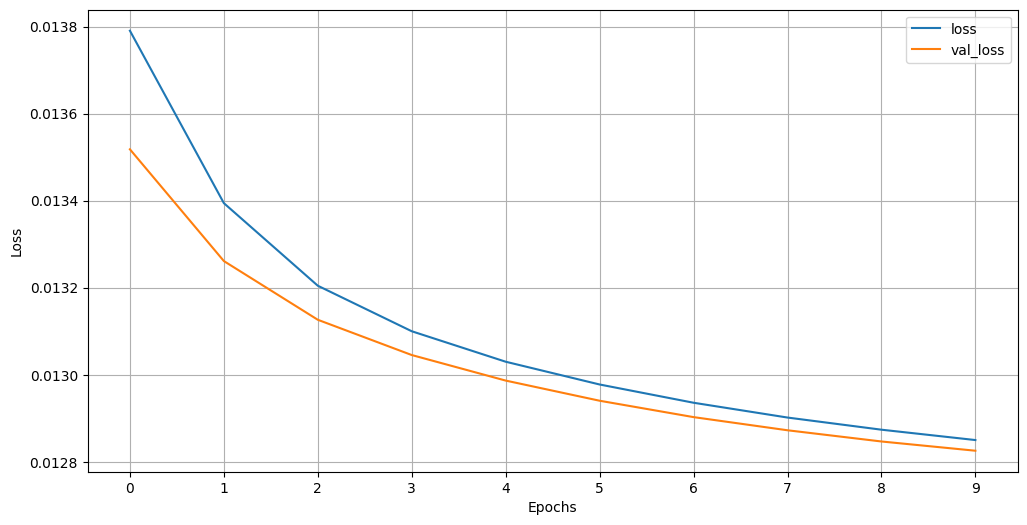

In [6]:
# model.history = model.fit(X_train, y_train, epochs = 10000, validation_split= 0.2, callbacks = [early_stopping], verbose = 1)

plot_callback = tool.create_plot_callback(["loss","val_loss"])
model.history = model.fit(X_train, y_train, batch_size = 64, epochs = 10, validation_split= 0.1,
                          callbacks = [plot_callback, early_stopping], verbose = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


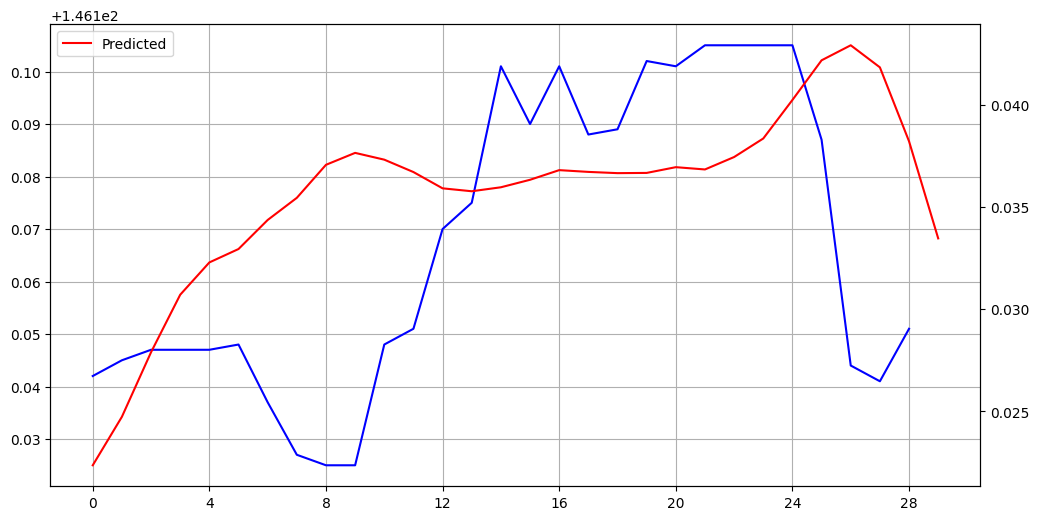

In [22]:
results = model.predict(X_test)

y_hat = results[:].flatten()


compare_price = raw_df.tail(test_size)
y = compare_price.close[1: ].values
tool.plot_predict(y_hat, y)



(30, 1)
predicted next day : [-0.00475653] 



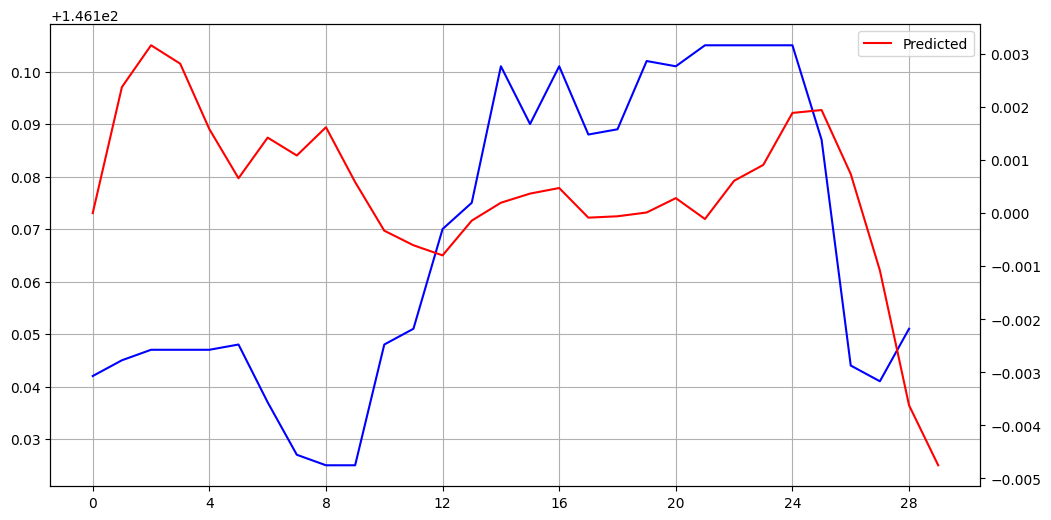

In [23]:
import numpy as np

signal = []
next_day = 0
lengh = results.shape[0]

print(results.shape)

for i in range(lengh):
  if i == 0:
    signal.append([0])
  elif i < lengh -1 :
    signal.append(results[i] - results[i - 1])
  else:
    next_day = results[i] - results[i - 1]
    signal.append(next_day)

print(f"predicted next day : {next_day} \n")

y_hat = np.array(signal)
tool.plot_predict(y_hat, y)



In [24]:
import pandas as pd
y_hat = y_hat[: -1].flatten()

y = y_test[1:]

evalu  = pd.DataFrame({"y_hat": y_hat, "y": y})
tool.show_evaluation(evalu)


Win Value Counts: 
win
-1    14
 1     9
 0     6

Balance: -4.56 %

Comparison DataFrame:

        y_hat       y  win
0   0.000000  0.0034   -1
1   0.002376  0.0021    1
2   0.003164  0.0014    1
3   0.002817  0.0000    0
4   0.001583  0.0000    0
5   0.000657  0.0007    1
6   0.001423 -0.0068   -1
7   0.001086 -0.0068   -1
8   0.001618 -0.0014   -1
9   0.000585  0.0000    0
10 -0.000332  0.0157   -1
11 -0.000607  0.0021   -1
12 -0.000798  0.0130   -1
13 -0.000143  0.0048   -1
14  0.000195  0.0226    1
15  0.000367 -0.0034   -1
16  0.000473  0.0068    1
17 -0.000086 -0.0089    1
18 -0.000061  0.0000    0
19  0.000011  0.0089    1
20  0.000282 -0.0007   -1
21 -0.000112  0.0027   -1
22  0.000609  0.0000    0
23  0.000908  0.0034    1
24  0.001889  0.0000    0
25  0.001943 -0.0048   -1
26  0.000736 -0.0294   -1
27 -0.001082 -0.0014    1
28 -0.003625  0.0068   -1


In [25]:
tool.show_naive(compare_price)

Win Value Counts: 
win
-1    12
 1    11
 0     6

Balance: 1.88 %

Comparison DataFrame:

      y_hat       y  win
0   0.0014  0.0034    1
1   0.0034  0.0021    1
2   0.0021  0.0014    1
3   0.0014  0.0000    0
4   0.0000  0.0000    0
5   0.0000  0.0007   -1
6   0.0007 -0.0068   -1
7  -0.0068 -0.0068    1
8  -0.0068 -0.0014    1
9  -0.0014  0.0000    0
10  0.0000  0.0157   -1
11  0.0157  0.0021    1
12  0.0021  0.0130    1
13  0.0130  0.0048    1
14  0.0048  0.0226    1
15  0.0226 -0.0034   -1
16 -0.0034  0.0068   -1
17  0.0068 -0.0089   -1
18 -0.0089  0.0000    0
19  0.0000  0.0089   -1
20  0.0089 -0.0007   -1
21 -0.0007  0.0027   -1
22  0.0027  0.0000    0
23  0.0000  0.0034   -1
24  0.0034  0.0000    0
25  0.0000 -0.0048   -1
26 -0.0048 -0.0294    1
27 -0.0294 -0.0014    1
28 -0.0014  0.0068   -1


In [17]:
from datetime import datetime

today = datetime.today().date().strftime("%Y%m%d")
model.save(f"model-{symbol}-{timeframe}-{today}.keras")